In [ ]:
from models._config import C
from dataset.RadarDataset import RadarSignalDataset  


c = C()
if __name__ == "__main__":
    datajson = c.dataload(csv=True, mode='train')
    dataset = RadarSignalDataset(datajson, c.signalTypes[0:c.typeSize], snr_max=17)

<<Loading Train Data [True]>>


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
from matplotlib import pyplot as plt
    
# Temporal Attention Layer (Zero-padding에 대한 가중치 조정 포함)
class SelfAttention(nn.Module):
    def __init__(self, hidden_size):
        super(SelfAttention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(hidden_size * 2, hidden_size)  # 
        self.v = nn.Parameter(torch.rand(hidden_size)) # 
        
    def forward(self, hidden_states, mask=None):
        """
        hidden_states: [batch_size, seq_len, hidden_size * 2]
        mask: [batch_size, seq_len] - zero-padding mask
        """
        attn_weights = torch.tanh(self.attn(hidden_states))  # [batch_size, seq_len, hidden_size]
        attn_weights = attn_weights.matmul(self.v)           # [batch_size, seq_len]
        attn_weights = F.softmax(attn_weights, dim=1)        # [batch_size, seq_len]에서 softmax로 중요도 결정
        
        # 가중치를 반영하여 각 타임 스텝의 hidden state를 곱해줌
        context = torch.sum(hidden_states * attn_weights.unsqueeze(-1), dim=1)  # [batch_size, hidden_size * 2]
        return context, attn_weights

class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=0.3)
        
        self.attention = SelfAttention(hidden_size)
        
        self.fc = nn.Linear(hidden_size * 2, num_classes)  
        
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, lengths, lstm_outputs=False):
        device = self.device
        x = x.to(device)
        lengths = lengths.to(device)
        print("f", x.device, lengths.device)
        batch_size, seq_len, _ = x.size()

        h0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size, device=device)
        c0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size, device=device)
        packed_x = rnn_utils.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        
        packed_out, (hn, cn) = self.lstm(packed_x, (h0, c0))
        out, _ = rnn_utils.pad_packed_sequence(packed_out, batch_first=True)
        mask = torch.arange(seq_len).expand(batch_size, seq_len).to(device) < lengths.unsqueeze(1).to(device)
        
        context, attn_weights = self.attention(out, mask) 
        
        out_last = self.dropout(context) 
        out_fc = self.fc(out_last) 
                
        if lstm_outputs:
            return out_fc, out, attn_weights
        else:
            return out_fc


    @staticmethod        
    def collate(batch):
        data, labels, snrs, lengths = zip(*batch)
        
        data_pad = rnn_utils.pad_sequence([torch.tensor(seq, dtype=torch.float32) for seq in data], batch_first=True)
        
        labels = torch.tensor([c.label_mapping[label] for label in labels], dtype=torch.long)
        snrs = torch.tensor(snrs, dtype=torch.int64)
        lengths = torch.tensor(lengths, dtype=torch.int64)  # 시퀀스 길이를 함께 전달

        return data_pad, labels, snrs, lengths
    



Barker 0
Barker 2
Barker 4
Barker 6
Barker 8
Barker 10
Barker 12
Barker 14
8
tensor([0])
tensor([2])


IndexError: index 1 is out of bounds for dimension 0 with size 1

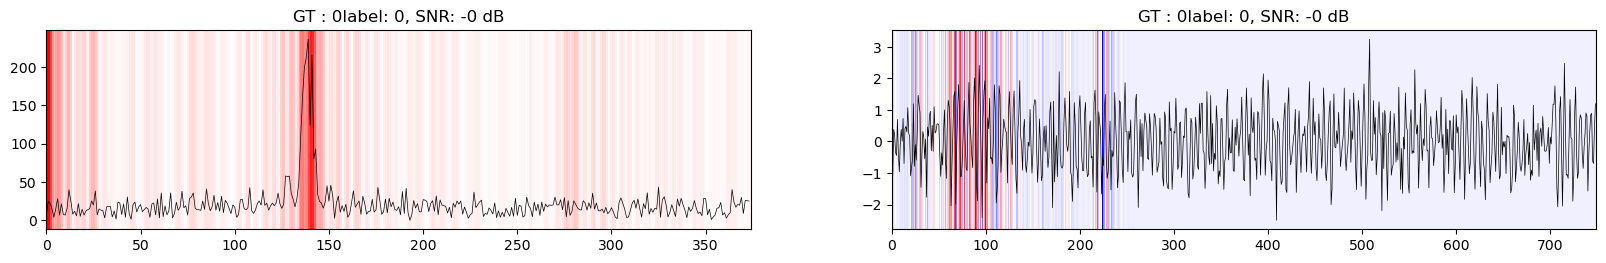

In [84]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from models.LSTM import BiLSTM


class LRP:
    def __init__(self, model, device, epsilon=1e-6):
        self.model = model
        self.epsilon = epsilon
        self.device = device
    
    def relevance(self, x, lengths, target=None):
        x = x.to(self.device)
        lengths = lengths.to(self.device)
        output, h, a = self.model(x, lengths, lstm_outputs=True)
        target = torch.argmax(output, dim=1) if target is None else target
        # Output shape: torch.Size([B, cls])
        # Hidden states shape: torch.Size([B, T, H*2])
        # Attention weights shape: torch.Size([B, T])
        # Context shape: torch.Size([B, H*2])
        
        r = torch.zeros_like(output)
        for i in range(output.size(0)):
            r[i, target[i]] = output[i, target[i]] # Target class에 대한 relevance만 생존
        
        r_c = self.bpp_fc(h, r)
        r_h = self.bpp_att(r_c, h, a)
        r_x = self.bpp_bilstm(r_h, h, x, lengths)
        
        # ground truth
        gt_label = torch.argmax(output, dim=1)
        return r_x, gt_label
    
    def lstm_gates(self, x_t, h_prev, W_ih, W_hh, b_ih, b_hh, cl_prev):
        x_t = x_t.to(self.device)
        h_prev = h_prev.to(self.device)
        cl_prev = cl_prev.to(self.device)
        
        gates = torch.matmul(W_ih, x_t) + torch.matmul(W_hh, h_prev) + b_ih + b_hh
        i_t, f_t, o_t, g_t = torch.chunk(gates, 4, dim=0)
        
        i_t = torch.sigmoid(i_t)
        f_t = torch.sigmoid(f_t)
        o_t = torch.sigmoid(o_t)
        cl_t = f_t * cl_prev + i_t * torch.tanh(g_t)
        
        return (f_t, i_t, o_t, cl_t)
        
    def bpp_bilstm(self, rel_h, h, x, lengths):
        B, T, H = h.size()
        H = H // 2
        D = x.size(-1)
        
        rel_x_fw = torch.zeros(B, T, D)                     # [B, T, D]
        rel_cl_fw_t1 = torch.zeros(B, H)                    # [B, H]
        W_ih = self.model.lstm.weight_ih_l0                             # [4*h, input_size]
        W_hh = self.model.lstm.weight_hh_l0                             # [4*h, hidden_size]
        b_ih = self.model.lstm.bias_ih_l0
        b_hh = self.model.lstm.bias_hh_l0
        
        rel_x_bw = torch.zeros(B, T, 2)
        rel_cl_bw_t1 = torch.zeros(B, H)
        W_ih_bw = self.model.lstm.weight_ih_l0_reverse
        W_hh_bw = self.model.lstm.weight_hh_l0_reverse
        b_ih_bw = self.model.lstm.bias_ih_l0_reverse
        b_hh_bw = self.model.lstm.bias_hh_l0_reverse
        
        # relevance는 cell state와 gate 값들을 통해 전파됨
        # rel_h_t : [B, T, sigma]
        # rel_x_fw[i, t] : [d] / rel_cl_fw_t1[i] : [h]
        for i in range(B):                                    # B
            h_prev_fw = torch.zeros(H)
            cl_prev_fw = torch.zeros(H)
            for t in reversed(range(T)):                      # T
                if t < lengths[i]:
                    x_t = x[i, t]                             # [H]
                    rel_h_fw_t = rel_h[i, t, :H]              # [H]
                    
                    f_t, i_t, o_t, cl_t = self.lstm_gates(x_t, h_prev_fw, W_ih, W_hh, b_ih, b_hh, cl_prev_fw) # [H]
                    rel_x_fw[i, t], rel_cl_fw_t1[i] = self.bpp_lstm_cell(rel_h_fw_t, rel_cl_fw_t1[i], 
                                                                            f_t, o_t, cl_t, W_ih)              
                    cl_prev_fw = cl_t
            
            h_prev_bw = torch.zeros(H)
            cl_prev_bw = torch.zeros(H)
            for t in range(T):
                if t < lengths[i]:
                    x_t = x[i, t]
                    rel_h_bw_t = rel_h[i, t, H:]
                    bf_t, bi_t, bo_t, bcl_t = self.lstm_gates(x_t, h_prev_bw, W_ih_bw, W_hh_bw, b_ih_bw, b_hh_bw, cl_prev_bw)
                    rel_x_bw[i, t], rel_cl_bw_t1[i] = self.bpp_lstm_cell(rel_h_bw_t, rel_cl_bw_t1[i], 
                                                                            bf_t, bo_t, bcl_t, W_ih_bw)
                    cl_prev_bw = bcl_t
                    
        rel_x = rel_x_fw + rel_x_bw
        return rel_x
        
    def bpp_lstm_cell(self, rel_h_t, rel_cl_t1, f_t, o_t, cl_t, W_ih):
        rel_cl_t = rel_cl_t1.to(self.device) + rel_h_t * o_t * (1 - torch.tanh(cl_t) ** 2)  # 전체 흐름 고려
    
        # 현재 시점에서 forget gate를 통해 이전 시점으로 relevance 전파
        rel_cl_t1 = rel_cl_t * f_t
        
        # Input gate를 통해 입력으로 relevance 전파 (i_t 반영)
        _, _, W_ih_o, W_ih_cl = torch.chunk(W_ih, 4, dim=0)  # input gate 가중치 추출
        
        # Output gate를 통한 relevance 전파
        rel_x_o = torch.matmul(W_ih_o.T, rel_cl_t * o_t)  # output gate 사용
        # Cell state를 통한 relevance 전파
        rel_x_cl = torch.matmul(W_ih_cl.T, rel_cl_t * torch.tanh(cl_t))  # cell state 사용
        
        # input gate를 통해 relevance 전파 (i_t 반영)
        rel_x_t = rel_x_o + rel_x_cl  # 최종 relevance 계산
        
        return rel_x_t, rel_cl_t1
        
    def bpp_att(self, r_c, h, w):
        rel_h = torch.zeros_like(h)
        for i in range(h.size(0)):
            rel_h_t = r_c[i].unsqueeze(0) * w[i].unsqueeze(-1)
            rel_h[i] = rel_h_t

        return rel_h
    
    def bpp_fc(self, c, r):
        fc_W = self.model.fc.weight
        rel_c = torch.zeros_like(c)
        for i in range(r.size(0)):
            for j in range(r.size(1)):
                rel_c[i] += (c[i]*fc_W[j]) * r[i, j] / (fc_W[j].abs().sum() + self.epsilon)
        return rel_c

import numpy as np


def normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    norm = (data - min_val) / (max_val - min_val + 1e-6)
    # norm[norm < 0] = 0
    return norm

def fft_transform(data_real, data_imag):
    complex_signal = data_real + 1j * data_imag     # 복소수 신호로 변환
    fft_data = np.fft.fft(complex_signal)           # FFT 적용
    fft_amplitude = np.abs(fft_data)                # 주파수 스펙트럼의 크기
    return fft_amplitude[:len(fft_amplitude) // 2] 


def explain_set(config, train_dataset):
    device = config.device
    model = BiLSTM(input_size=2, hidden_size=128, num_layers=2, num_classes=12)

    state_dict = {}
    for k, v in torch.load('./ckpts/result_loss.pt').items():
        nk = k.replace('module.', '')
        state_dict[nk] = v
        
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()   
   
    lrp = LRP(model, device=device)
    
    with torch.no_grad():
        batch_size = 5
        fig = plt.figure(figsize=(20, 15))
        
        snr_values = [0, 2, 4, 6, 8, 10, 12, 14]
        snr_batch = []
        for snr in snr_values:
            for data_batch, labels_batch, snrs_batch, lengths_batch in train_dataset:
                if snrs_batch == snr and labels_batch == 'Barker':
                    print(labels_batch, snrs_batch)
                    snr_batch.append((data_batch, labels_batch, snrs_batch, lengths_batch))
                    break
        
        print(len(snr_batch))
        snr_batch = [(data_batch, labels_batch, snrs_batch, lengths_batch) 
                     for data_batch, labels_batch, snrs_batch, lengths_batch in train_dataset]
        batch = DataLoader(snr_batch, batch_size=batch_size, shuffle=False, collate_fn=model.collate)

        for batch_idx, (data_batch, labels_batch, snrs_batch, lengths_batch) in enumerate(batch):
            print(snrs_batch)
            r_scores, gt_label = lrp.relevance(data_batch, lengths_batch, target=labels_batch)
            seq_len = lengths_batch[batch_idx].item()  # 유효한 시퀀스 길이
            
            data_real = data_batch[batch_idx, :seq_len, 0].cpu().numpy()  # 실수부
            data_imag = data_batch[batch_idx, :seq_len, 1].cpu().numpy()  # 허수부
            data_fft = fft_transform(data_real, data_imag)
            
            rel_real = r_scores[batch_idx, :seq_len, 0].cpu().numpy()   # Relevance 실수부
            rel_imag = r_scores[batch_idx, :seq_len, 1].cpu().numpy()   # Relevance 허수부
            rel_fft = fft_transform(rel_real, rel_imag)
            
            data = data_real + data_imag
            rel = rel_real + rel_imag  
            
            rel = rel[:len(data)]
            rel_norm = normalize(rel)
            rel_fft = rel_fft[:len(data_fft)]
            rel_fft_norm = normalize(rel_fft)            

            ax1 = fig.add_subplot(batch_size, 2, 2*batch_idx+1)
            ax2 = fig.add_subplot(batch_size, 2, 2*batch_idx+2) 
            
            rel_heatmap = np.expand_dims(rel_norm, axis=0)
            rel_fft_heatmap = np.expand_dims(rel_fft_norm, axis=0)
            
            ax1.plot(data_fft, color='black', label='FFT Magnitude', linewidth=0.5)
            ax2.plot(data, color='black', label='Signal', linewidth=0.5)
            
            ax1.imshow(rel_fft_heatmap, cmap='bwr', aspect='auto', interpolation='nearest',
                    extent=[0, seq_len // 2, ax1.get_ylim()[0], ax1.get_ylim()[1]], zorder=0, vmin=-1, vmax=1)

            ax2.imshow(rel_heatmap, cmap='bwr', aspect='auto', interpolation='nearest',
                    extent=[0, seq_len, ax2.get_ylim()[0], ax2.get_ylim()[1]], zorder=0)
            
            
            ax1.set_title(f'GT : {gt_label[batch_idx]}label: {labels_batch[batch_idx]}, SNR: -{snrs_batch[batch_idx]} dB')
            ax2.set_title(f'GT : {gt_label[batch_idx]}label: {labels_batch[batch_idx]}, SNR: -{snrs_batch[batch_idx]} dB')
            
            if batch_idx >= batch_size - 1: 
                break  

    plt.tight_layout()
    plt.show()


from models._config import C
c = C()
explain_set(c, dataset)

In [ ]:
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from models.LSTM import BiLSTM

def complex_sep(data):
    data = data.replace('i', 'j')  # 'i'를 'j'로 변경하여 복소수 형식에 맞춤
    complex_numbers = data.split(',')  # 쉼표로 구분된 복소수 분리
    complex_list = []
    for num in complex_numbers:
        num = complex(num.strip())
        complex_list.append(num)
    return complex_list

def exaplin_set(data):
    model = BiLSTM(input_size=2, hidden_size=128, num_layers=2, num_classes=12)
    model.load_state_dict(torch.load('/home/kiwan/TSC_XAI/ckpts/ 0dB/LSTM_ 0dB_0.0073.pt'))
    model.eval()
    
    lrp = LRP(model)
    with torch.no_grad():
        x = torch.tensor(data, dtype=torch.float).unsqueeze(0)
        lengths = torch.tensor([len(data)], dtype=torch.long)
        relevance = lrp.get_relevance(x, lengths)
	
	
        
dataset = '/data/kiwan/dataset-CWD-1000/'
signals = ['Barker', 'Costas', 'Frank', 'LFM', 'P1', 'P2', 'P3', 'P4', 'T1', 'T2', 'T3', 'T4']

for signal in signals:
    real_parts = []
    plt.figure(figsize=(20, 5))
    data_dir = os.path.join(dataset, signal)
    data_file = os.listdir(data_dir)
    for ie, file in enumerate(data_file):
        with open(os.path.join(data_dir, file), 'r') as f:
            data = f.readlines()
            data = [complex_sep(d) for d in data]
            data = [item for sublist in data for item in sublist]
            
            

        for c in data:
            real_parts.append(c.real)

        plt.axvline(x=len(real_parts), color='r', linestyle='--')
            
        if ie == 5:
            break


    plt.plot(real_parts, label='Real Part')
    # plt.plot(imag_parts, label='Imaginary Part')
    plt.title(f'{signal} Signal: Real and Imaginary Parts over Time')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()
        

In [ ]:

def explain_set(train_dataset):
    model = BiLSTM(input_size=2, hidden_size=128, num_layers=2, num_classes=12)
    model.load_state_dict(torch.load('/home/kiwan/TSC_XAI/ckpts/ 0dB/LSTM_ 0dB_0.0073.pt'))
    model.eval()
    
    lrp = LRP(model)

    batch = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=model.collate)

    fig = plt.figure(figsize=(20, 15))

    with torch.no_grad():
        for data_batch, labels, snr, lengths in batch:
            for i in range(len(data_batch)):
                data = data_batch[i]
                seq_len = lengths[i].item()  
                print(seq_len)
                
                # LRP로 Relevance 스코어 계산
                r_scores = lrp.get_relevance(data, seq_len)

                real_part = data_batch[i][:, 0].cpu().numpy()  # 실수부
                r_scores_real = r_scores[:, 0].cpu().numpy()   # Relevance 실수부

                ax = fig.add_subplot(4, 2, i + 1)
                ax.plot(real_part, label='Real Part')
                ax.plot(r_scores_real, label='Relevance (Real Part)', linestyle='--')
                ax.set_title(f'Sample {i+1} (SNR: {snr[i]} dB)')
                ax.legend()

            break

    plt.tight_layout()
    plt.show()

explain_set(train_dataset)